In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyeit.mesh as mesh
import seaborn as sns
import tensorflow as tf
from PIL import Image
from pyeit.mesh.shape import thorax
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, perm_deviation, plot_reconstruction, show_mesh
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2023-11-08 15:50:14.549617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 15:50:14.549716: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 15:50:14.549750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 15:50:14.557160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id="start"></a>
# Predict Lung Wings Size inside the Thorax

- [Data Overview](#data_overview)
- [**VAE**](#vae)
- [Prepare Data for Mapper Training](#prepdataformapper)
- [**Mapper Engineering**](#trainmapper)
    - [Stacked Mapper](#stackedmapper)
    - [Single Layer Mapper](#singlelayer)
    - [LSTM Mapper](#lstmmapper)
    - [Stacked LSTM Mapper](#stackedlstmmapper)
- [**Comparison**](#comparison)

<a id="data_overview"></a>
## Data Overview

The thorax data consists of multiple very raw breathing-lung-cycles periods. Therefore two circles, representing the lung wings, inside a thorax-like mesh are changed in their radius.

![gif](../codes/breathing.gif)

In [2]:
l_path = "../data_thorax/h0=0.05_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=Truendiv=2/"

In [3]:
# load single simulation sample
tmp = np.load(l_path + "sample_000000.npz", allow_pickle=True)
tmp.files

['anomaly',
 'perm_array',
 'n_el',
 'h0',
 'v_empty',
 'v_obj',
 'dist_exc',
 'step_meas']

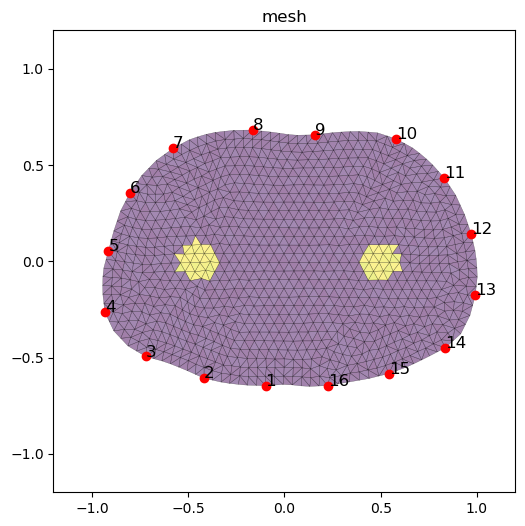

In [4]:
# create empty mesh:
mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"], fd=thorax)
mesh_obj.perm = tmp["perm_array"]
plot_mesh(mesh_obj)

In [5]:
V = np.load("../data_thorax/V.npy", allow_pickle=True)
perms = np.load("../data_thorax/perms.npy", allow_pickle=True)
radii = np.load("../data_thorax/radii.npy", allow_pickle=True)

tt_spl = 4000
V_train = V[:tt_spl]
V_test = V[tt_spl:]
perms_train = perms[:tt_spl]
np.random.shuffle(perms_train)
perms_test = perms[tt_spl:]
radii_train = radii[:tt_spl]
radii_test = radii[tt_spl:]

In [6]:
perms_train = perms[:tt_spl]

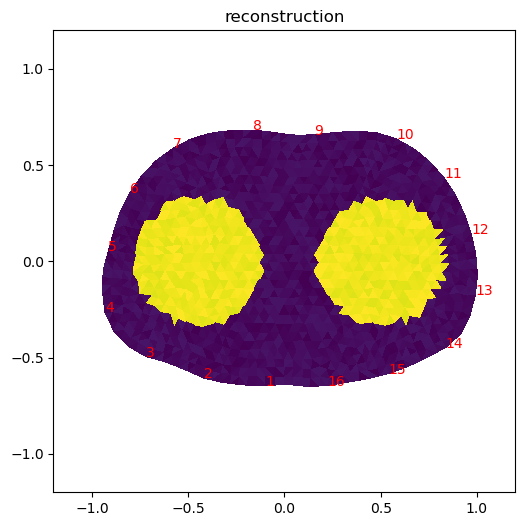

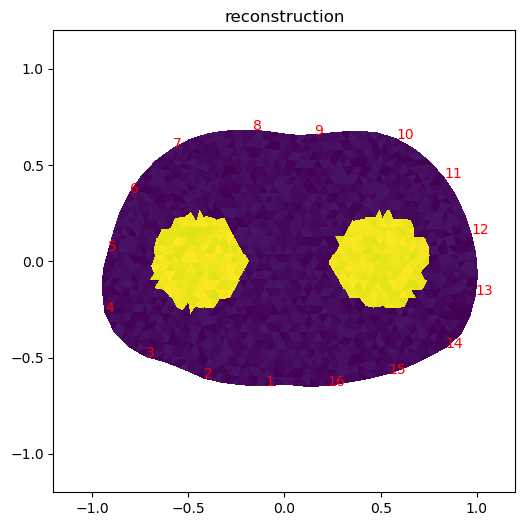

In [7]:
plot_reconstruction(mesh_obj, perms_train[0])
plot_reconstruction(mesh_obj, perms_train[1])

<a id="vae"></a>
## VAE

In [8]:
latent_dim = 8
from VAE_thorax import vae

Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1912)]               0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1912, 1)              0         ['input_1[0][0]']             
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 2400, 1)              0         ['reshape[0][0]']             
 g1D)                                                                                             
                                                                                                  
 conv1d (Conv1D)             (None, 2400, 16)             160       ['zero_padding1d[0][

2023-11-08 15:50:53.736362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12769 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-08 15:50:53.738089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46259 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "VAE_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                144       
                                                                 
 dense_5 (Dense)             (None, 64)                1088      
                                                                 
 dense_6 (Dense)             (None, 512)               33280     
                                                                 
 dense_7 (Dense)             (None, 1024)              525312    
                                                                 
 dense_8 (Dense)             (None, 1920)              1968000   
                                                                 
 reshape_1 (Reshape)         (None, 30, 64)            

In [9]:
load_vae = True

if load_vae:
    vae.build(input_shape=())
    vae.load_weights("../data_thorax/vae_w.h5")
else:
    vae.compile(Adam(), loss=tf.losses.mean_squared_error)
    history = vae.fit(perms_train, epochs=20, batch_size=32)

In [10]:
if not load_vae:
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [11]:
V = np.load("../data_thorax/V.npy", allow_pickle=True)
perms = np.load("../data_thorax/perms.npy", allow_pickle=True)
radii = np.load("../data_thorax/radii.npy", allow_pickle=True)

2023-11-08 15:50:55.883889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


1/1 [==============================] - 0s 22ms/step


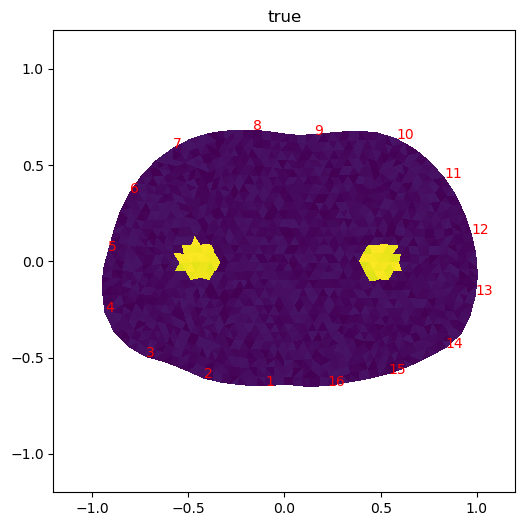

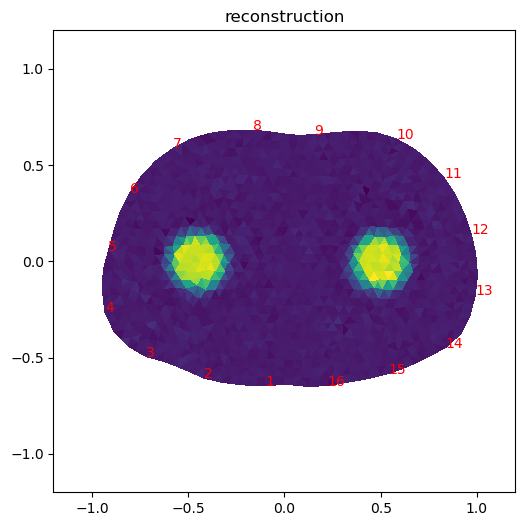

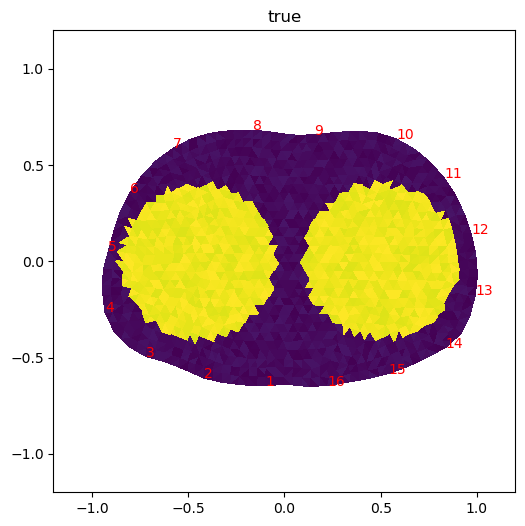

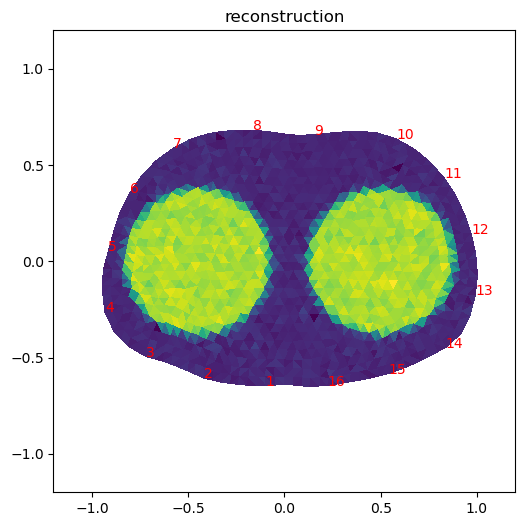

In [12]:
# reset order to default
perms_train = perms[:tt_spl]
_, _, z0 = vae.encoder.predict(np.expand_dims(perms_train[0, :], 0))
_, _, z50 = vae.encoder.predict(np.expand_dims(perms_train[50, :], 0))

plot_reconstruction(mesh_obj, perms_train[0, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z0)))
plot_reconstruction(mesh_obj, perms_train[50, :], title="true")
plot_reconstruction(mesh_obj, np.concatenate(vae.decoder.predict(z50)))

In [13]:
train_z_mean, train_z_log_var, train_z = vae.encoder.predict(perms_train)
test_z_mean, test_z_log_var, test_z = vae.encoder.predict(perms_test)
all_z_mean, all_z_log_var, all_z = vae.encoder.predict(perms)

313/313 [==============================] - 1s 3ms/step


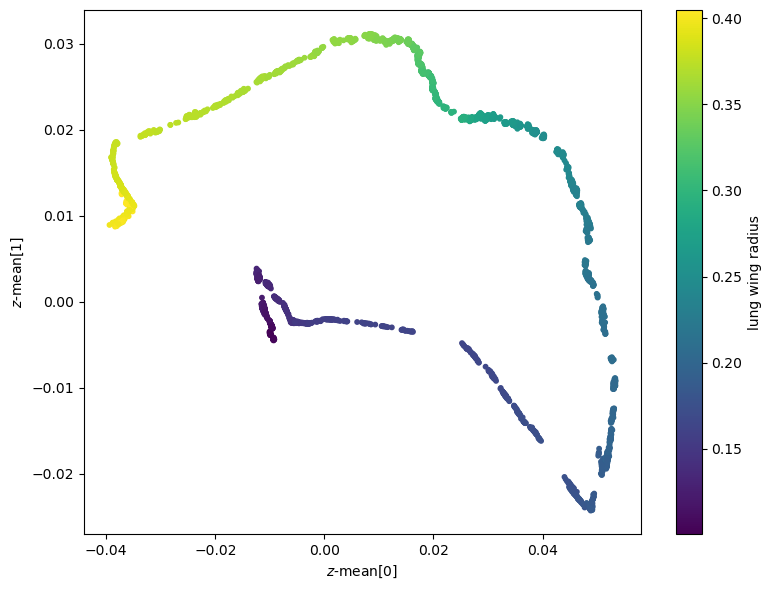

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(train_z_mean[:, 0], train_z_mean[:, 1], c=radii_train, s=10)
plt.xlabel("$z$-mean[0]")
plt.ylabel("$z$-mean[1]")
# plt.axis('off')
plt.tight_layout()
# plt.savefig("../../beauty_of_latent_spaces/1.pdf")
plt.colorbar(label="lung wing radius")
plt.show()

In [15]:
# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2)
# latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data
latent_space_2d = tsne.fit_transform(train_z_mean)  # latent data

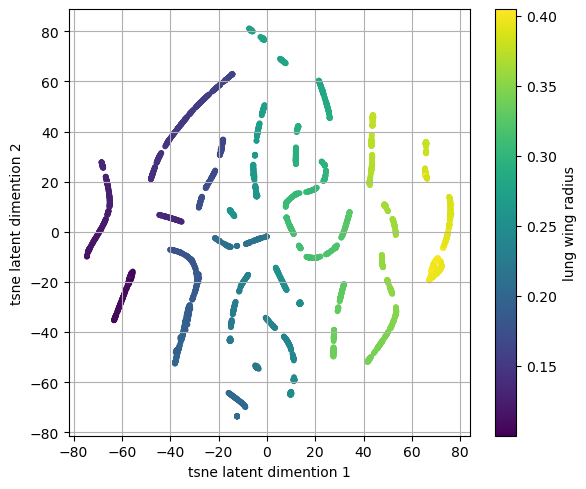

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], c=radii_train, s=10)
plt.xlabel("tsne latent dimention 1")
plt.ylabel("tsne latent dimention 2")
plt.colorbar(label="lung wing radius")
plt.grid()
plt.tight_layout()
# plt.savefig("../../beauty_of_latent_spaces/5.pdf")
plt.show()

<a id="prepdataformapper"></a>
## Prepare Data for Mapper

In [17]:
V = np.load("../data_thorax/V.npy", allow_pickle=True)
perms = np.load("../data_thorax/perms.npy", allow_pickle=True)
radii = np.load("../data_thorax/radii.npy", allow_pickle=True)

tt_spl = 4000
V_train = V[:tt_spl]
V_test = V[tt_spl:]
perms_train = perms[:tt_spl]
perms_test = perms[tt_spl:]
radii_train = radii[:tt_spl]
radii_test = radii[tt_spl:]

In [18]:
nseg = 4

# train data
X_train = [V_train[n : n + nseg, :] for n in range(V_train.shape[0] - nseg + 1)]
X_train = np.array(X_train)

Y_train_v = V_train[nseg - 1 :]
Y_train_perms = perms_train[nseg - 1 :]
_, _, Y_train = vae.encoder.predict(Y_train_perms)


# test data
X_test = [V_test[n : n + nseg, :] for n in range(V_test.shape[0] - nseg + 1)]
X_test = np.array(X_test)

Y_test_v = V_test[nseg - 1 :]
Y_test_perms = perms_test[nseg - 1 :]
_, _, Y_test = vae.encoder.predict(Y_test_perms)

188/188 [==============================] - 1s 4ms/step


In [19]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print(np.allclose(X_train[0, nseg - 1, :], Y_train_v[0, :]))
print(np.allclose(X_test[0, nseg - 1, :], Y_test_v[0, :]))

(3997, 4, 192) (3997, 8)
(5997, 4, 192) (5997, 8)
True
True


<a id="trainmapper"></a>
# Mapper Engineering

- [Stacked Mapper](#stackedmapper)
- [Single Layer Mapper](#singlelayer)
- [LSTM Mapper](#lstmmapper)
- [Stacked LSTM Mapper](#stackedlstmmapper)
- [Comparison](#comparison)

In [20]:
batch_size_m = 64
epochs_m = 25
lossf_m = tf.losses.mean_squared_error

<a id="stackedmapper"></a>
## Stacked Mapper

In [21]:
def stacked_mapper(input_shape=(4, 192, 1), latent_dim=8):

    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D((0, 32))(mapper_inputs)

    x = layers.Conv2D(8, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Conv2D(16, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(latent_dim)(x)
    return Model(mapper_inputs, x)


mapper_stacked = stacked_mapper()
mapper_stacked.compile(Adam(), loss=lossf_m)
mapper_stacked.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 192, 1)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 4, 256, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 8)         40        
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 64, 16)         528       
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

In [22]:
history_stacked = mapper_stacked.fit(
    X_train,
    Y_train,
    epochs=epochs_m,
    batch_size=batch_size_m,
    # validation_data=(X_test,Y_test)
)

Epoch 1/25


2023-11-08 15:51:15.005596: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f71b0783750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 15:51:15.005648: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-08 15:51:15.005658: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-08 15:51:15.009937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 15:51:15.140061: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 3s 6ms/step - loss: 0.9793
Epoch 2/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9145
Epoch 3/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8857
Epoch 4/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8821
Epoch 5/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8807
Epoch 6/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8789
Epoch 7/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8791
Epoch 8/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8782
Epoch 9/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8780
Epoch 10/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8778
Epoch 11/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8764
Epoch 12/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8771
Epoch 13/25
63/63 [==============================] - 0s 4ms/

In [53]:
# mapper_stacked.save_weights("../data_thorax/mapper_stacked_w.h5")

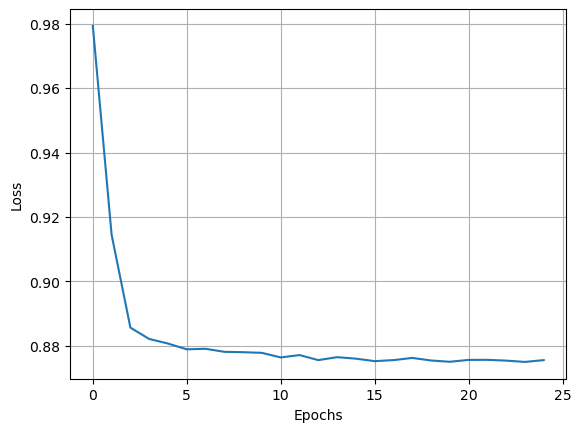

In [24]:
plt.plot(history_stacked.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [25]:
Perm_pred_stacked = vae.decoder.predict(mapper_stacked.predict(X_test))

188/188 [==============================] - 1s 3ms/step


In [26]:
err_stacked = list()
for i in tqdm(range(Perm_pred_stacked.shape[0])):
    err_stacked.append(perm_deviation(perms_test[i, :], Perm_pred_stacked[i, :]))

100%|██████████| 5997/5997 [00:00<00:00, 53170.34it/s]


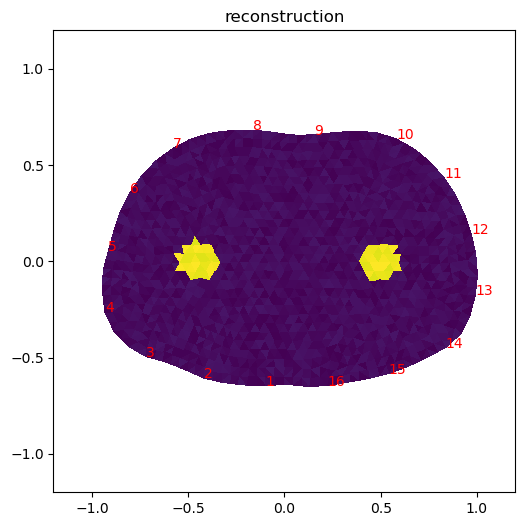

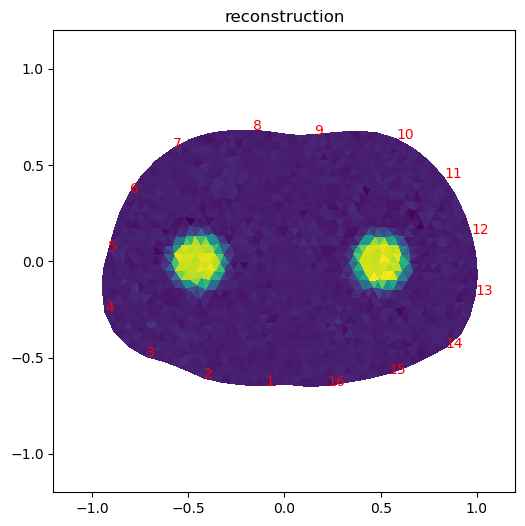

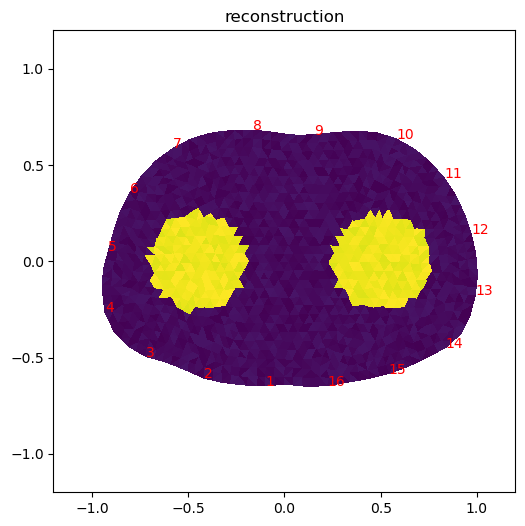

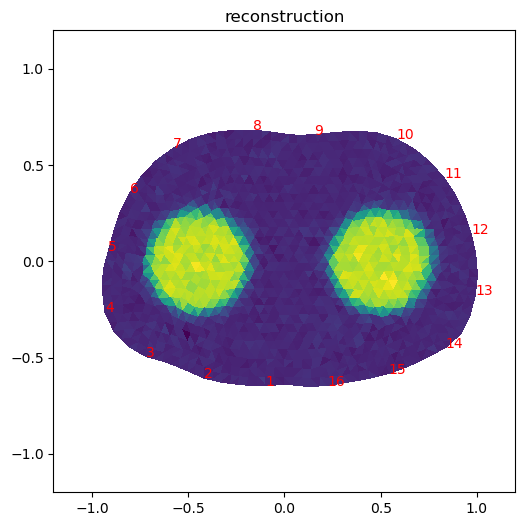

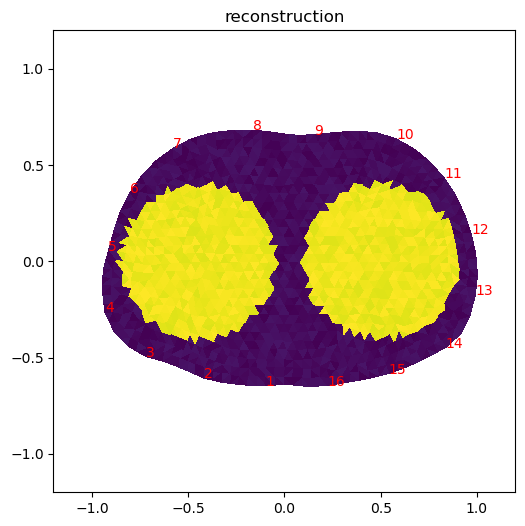

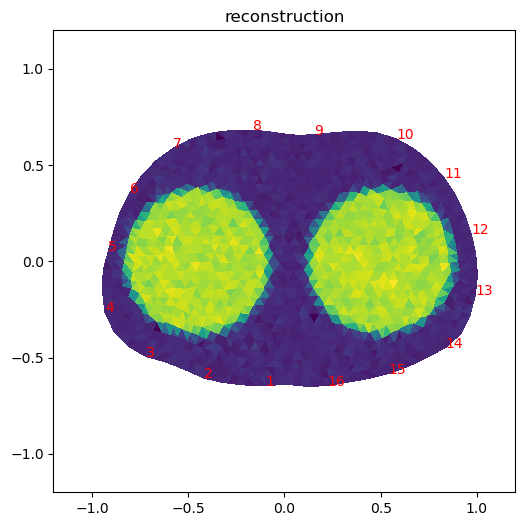

In [27]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_stacked[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_stacked[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_stacked[50, :])

<a id="singlelayer"></a>
## Single Layer Mapper

In [28]:
def mapper_singlelayer(input_shape=(192,), latent_dim=8):

    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation="relu")(mapper_inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(mapper_inputs, x)


mapper_singlelayer = mapper_singlelayer()
mapper_singlelayer.compile(Adam(), loss=lossf_m)
mapper_singlelayer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192)]             0         
                                                                 
 dense_10 (Dense)            (None, 128)               24704     
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
Total params: 35704 (139.47 KB)
Trainable params: 35704 (13

In [29]:
history_singlelayer = mapper_singlelayer.fit(
    X_train[:, 0, :],
    Y_train,
    epochs=epochs_m,
    batch_size=batch_size_m,
)

Epoch 1/25
63/63 [==============================] - 2s 4ms/step - loss: 0.9951
Epoch 2/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 3/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 4/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 5/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 6/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 7/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 8/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 9/25
63/63 [==============================] - 0s 5ms/step - loss: 0.9947
Epoch 10/25
63/63 [==============================] - 0s 5ms/step - loss: 0.9947
Epoch 11/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 12/25
63/63 [==============================] - 0s 4ms/step - loss: 0.9947
Epoch 13/25
63/63 [==============================

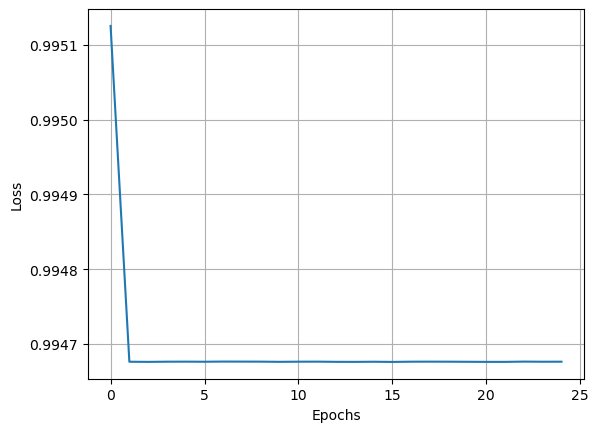

In [30]:
plt.plot(history_singlelayer.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [54]:
# mapper_singlelayer.save_weights("../data_thorax/mapper_singlelayer_w.h5")

In [32]:
Perm_pred_singlelayer = vae.decoder.predict(mapper_singlelayer.predict(X_test[:, 0, :]))

188/188 [==============================] - 1s 3ms/step


In [33]:
err_singlelayer = list()
for i in tqdm(range(Perm_pred_singlelayer.shape[0])):
    err_singlelayer.append(
        perm_deviation(perms_test[i, :], Perm_pred_singlelayer[i, :])
    )

100%|██████████| 5997/5997 [00:00<00:00, 52159.83it/s]


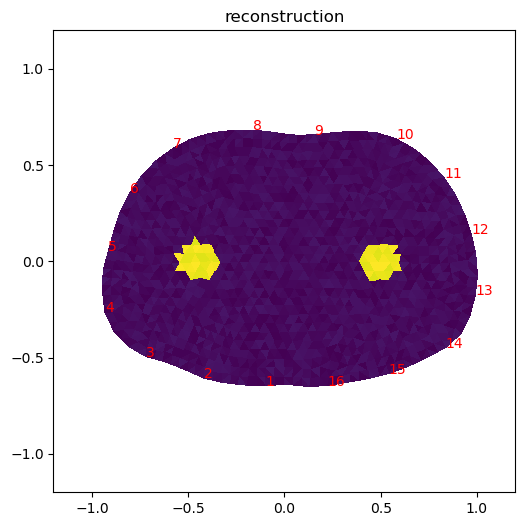

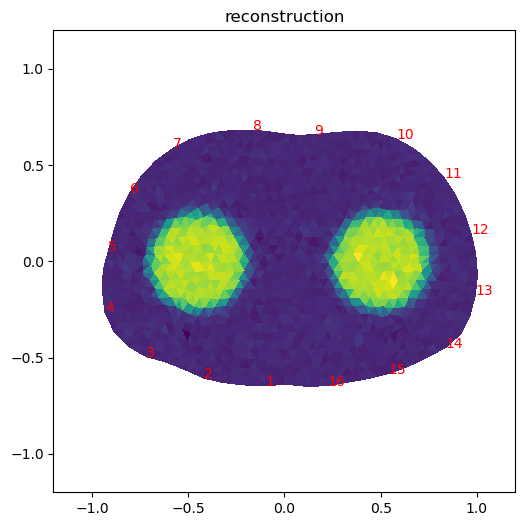

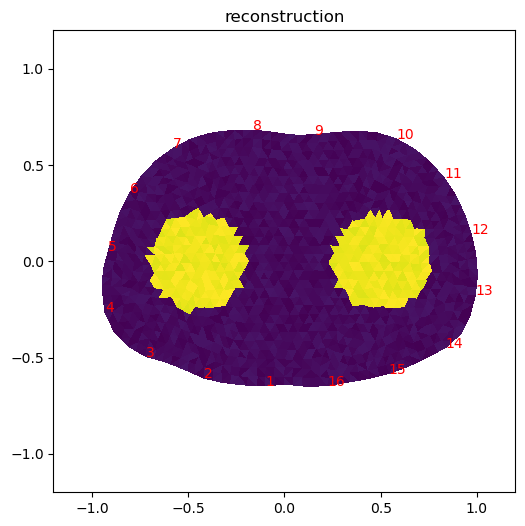

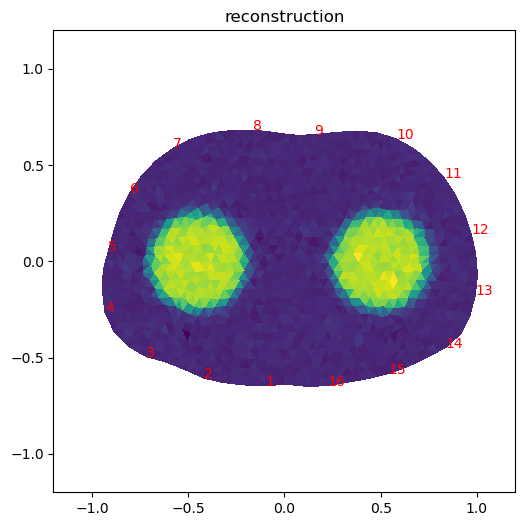

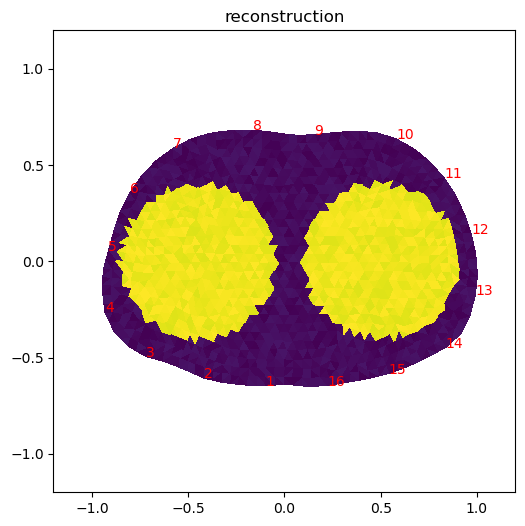

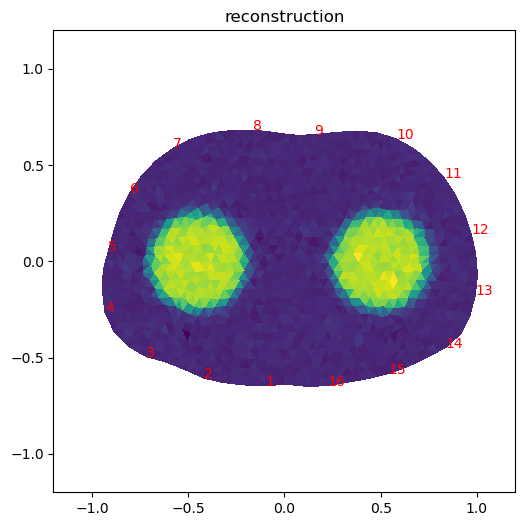

In [34]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_singlelayer[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_singlelayer[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_singlelayer[50, :])

<a id="lstmmapper"></a>
## LSTM Mapper

In [35]:
def mapper_lstm(input_shape=(4, 192, 1), latent_dim=8):
    def Slice(s):
        def func(x):
            return x[:, s, :]

        return func

    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D((0, 32))(mapper_inputs)

    # create shared layers:
    batch_normalization = layers.BatchNormalization()
    conv1d_08 = layers.Conv1D(8, strides=2, kernel_size=5)
    conv1d_16 = layers.Conv1D(16, strides=2, kernel_size=5)
    conv1d_32 = layers.Conv1D(32, strides=2, kernel_size=5)
    dropout = layers.Dropout(0.25)
    flatten = layers.Flatten()

    dense = layers.Dense(latent_dim)

    con_list = []
    for s in range(input_shape[0]):
        x = layers.Lambda(Slice(s))(mapper_inputs)
        #x = dropout(x)
        #x = batch_normalization(x)
        x = conv1d_08(x)
        # x = batch_normalization(x)
        # x = dropout(x)
        x = conv1d_16(x)
        x = conv1d_32(x)
        x = flatten(x)
        # x = dropout(x)
        x = dense(x)

        con_list.append(x)

    x = layers.Concatenate(axis=1)(con_list)
    x = layers.Reshape((nseg, latent_dim))(x)
    x = layers.LSTM(latent_dim)(x)
    #x = layers.Dense(latent_dim, activation="softmax")(x)

    # x = dropout(x)
    return Model(mapper_inputs, x)


mapper_lstm = mapper_lstm()
mapper_lstm.compile(Adam(), loss=lossf_m)
mapper_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 4, 192, 1)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 192, 1)               0         ['input_4[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 192, 1)               0         ['input_4[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 192, 1)               0         ['input_4[0][0]']             
                                                                                            

In [36]:
history_lstm = mapper_lstm.fit(
    X_train, Y_train, epochs=epochs_m, batch_size=batch_size_m
)

Epoch 1/25
63/63 [==============================] - 4s 11ms/step - loss: 0.9656
Epoch 2/25
63/63 [==============================] - 1s 8ms/step - loss: 0.9118
Epoch 3/25
63/63 [==============================] - 0s 8ms/step - loss: 0.8940
Epoch 4/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8914
Epoch 5/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8908
Epoch 6/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8893
Epoch 7/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8888
Epoch 8/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8892
Epoch 9/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8889
Epoch 10/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8886
Epoch 11/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8879
Epoch 12/25
63/63 [==============================] - 1s 8ms/step - loss: 0.8875
Epoch 13/25
63/63 [=============================

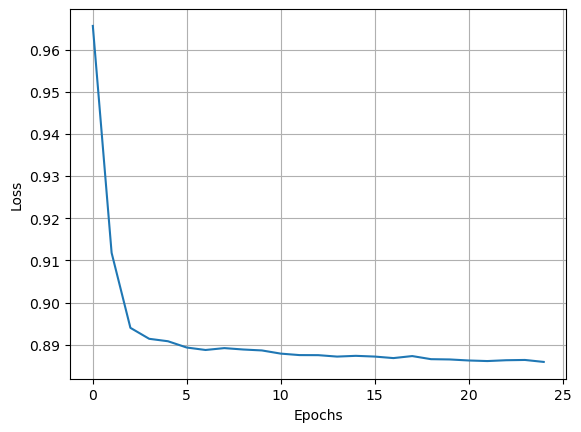

In [37]:
plt.plot(history_lstm.history["loss"])
# plt.plot(history_lstm.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [55]:
# mapper_lstm.save_weights("../data_thorax/mapper_lstm_w.h5")

In [39]:
Perm_pred_lstm = vae.decoder.predict(mapper_lstm.predict(X_test))

188/188 [==============================] - 1s 3ms/step


In [40]:
err_lstm = list()
for i in tqdm(range(Perm_pred_singlelayer.shape[0])):
    err_lstm.append((perm_deviation(perms_test[i, :], Perm_pred_lstm[i, :])))

100%|██████████| 5997/5997 [00:00<00:00, 53172.93it/s]


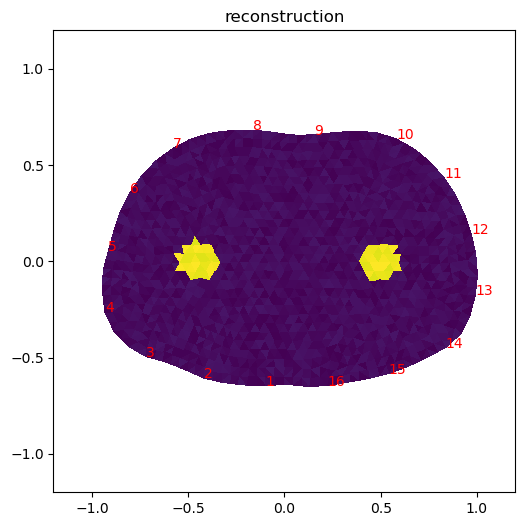

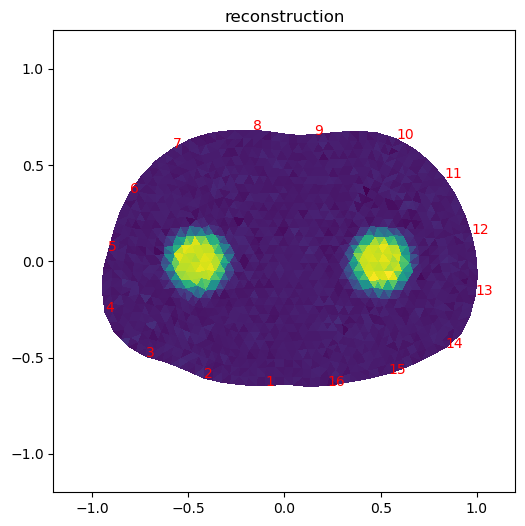

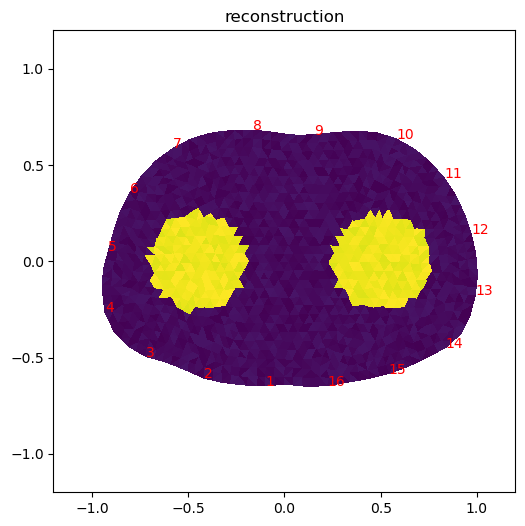

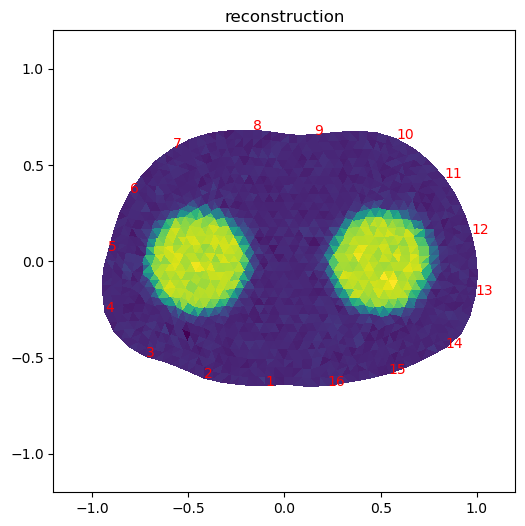

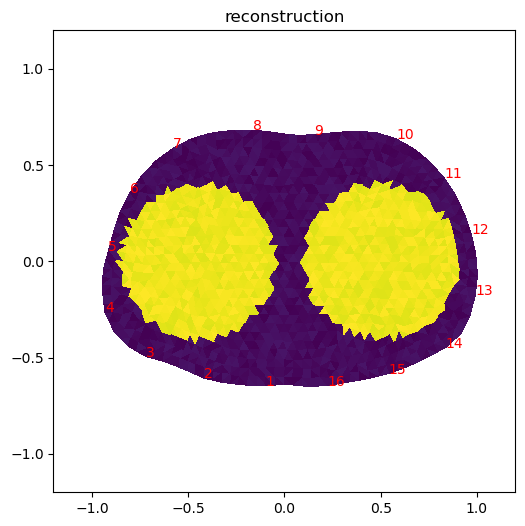

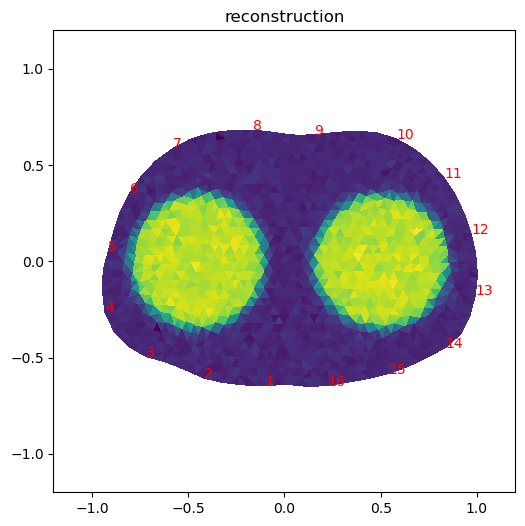

In [41]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_lstm[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_lstm[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_lstm[50, :])

<a id="stackedlstmmapper"></a>
## Stacked LSTM Mapper

In [42]:
def stacked_lstm_mapper(input_shape=(4, 192, 1), latent_dim=8):

    mapper_inputs = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D((0, 32))(mapper_inputs)

    x = layers.Conv2D(8, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Conv2D(16, strides=(2, 2), kernel_size=(2, 2), activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Reshape((4,256))(x)
    x = layers.LSTM(256)(x)
    
    x = layers.Dense(latent_dim)(x)
    return Model(mapper_inputs, x)


stacked_lstm_mapper = stacked_lstm_mapper()
stacked_lstm_mapper.compile(Adam(), loss=lossf_m)
stacked_lstm_mapper.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 192, 1)]       0         
                                                                 
 zero_padding2d_2 (ZeroPadd  (None, 4, 256, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 128, 8)         40        
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 64, 16)         528       
                                                                 
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                           

In [43]:
history_stacked_lstm = stacked_lstm_mapper.fit(
    X_train,
    Y_train,
    epochs=epochs_m,
    batch_size=batch_size_m,
    # validation_data=(X_test,Y_test)
)

Epoch 1/25
63/63 [==============================] - 2s 5ms/step - loss: 0.9357
Epoch 2/25
63/63 [==============================] - 0s 5ms/step - loss: 0.8808
Epoch 3/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8783
Epoch 4/25
63/63 [==============================] - 0s 4ms/step - loss: 0.8788
Epoch 5/25
63/63 [==============================] - 0s 5ms/step - loss: 0.8787
Epoch 6/25
63/63 [==============================] - 0s 5ms/step - loss: 0.8779
Epoch 7/25
63/63 [==============================] - 0s 5ms/step - loss: 0.8778
Epoch 8/25
63/63 [==============================] - 0s 5ms/step - loss: 0.8762
Epoch 9/25
63/63 [==============================] - 0s 6ms/step - loss: 0.8766
Epoch 10/25
63/63 [==============================] - 0s 6ms/step - loss: 0.8764
Epoch 11/25
63/63 [==============================] - 0s 6ms/step - loss: 0.8766
Epoch 12/25
63/63 [==============================] - 0s 6ms/step - loss: 0.8761
Epoch 13/25
63/63 [==============================

In [56]:
# stacked_lstm_mapper.save_weights("../data_thorax/stacked_lstm_mapper_w.h5")

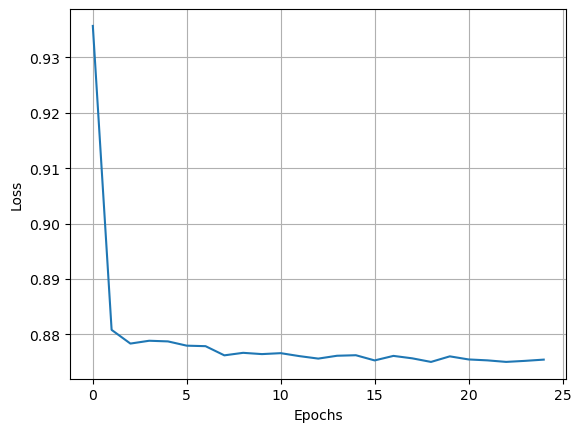

In [45]:
plt.plot(history_stacked_lstm.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [46]:
Perm_pred_stacked_lstm = vae.decoder.predict(stacked_lstm_mapper.predict(X_test))

188/188 [==============================] - 1s 3ms/step


In [47]:
err_stacked_lstm = list()
for i in tqdm(range(Perm_pred_stacked_lstm.shape[0])):
    err_stacked_lstm.append(perm_deviation(perms_test[i, :], Perm_pred_stacked_lstm[i, :]))

100%|██████████| 5997/5997 [00:00<00:00, 52363.86it/s]


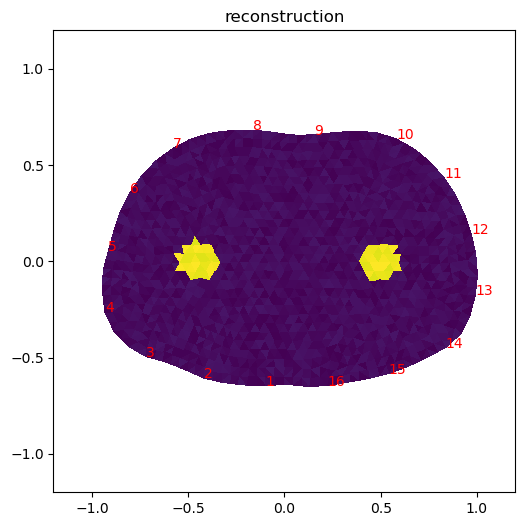

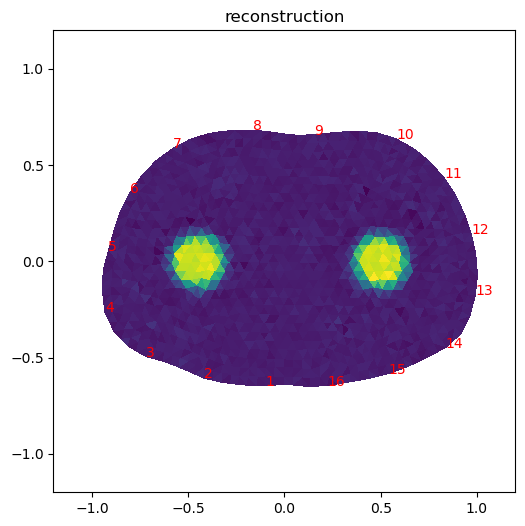

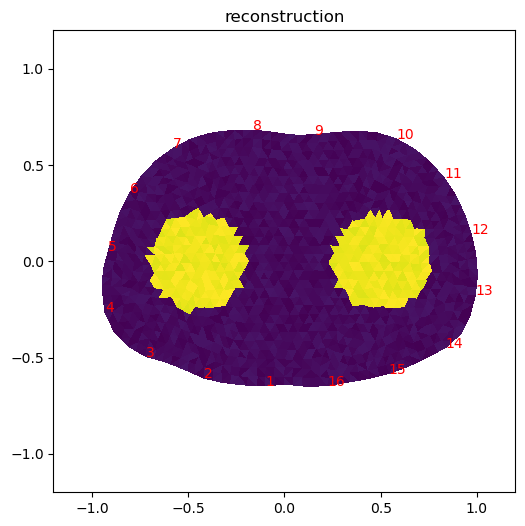

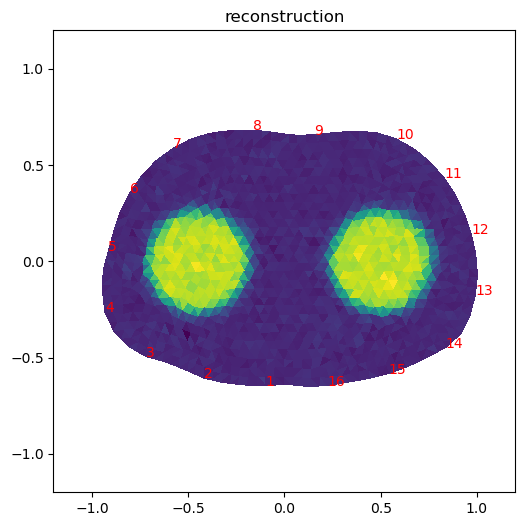

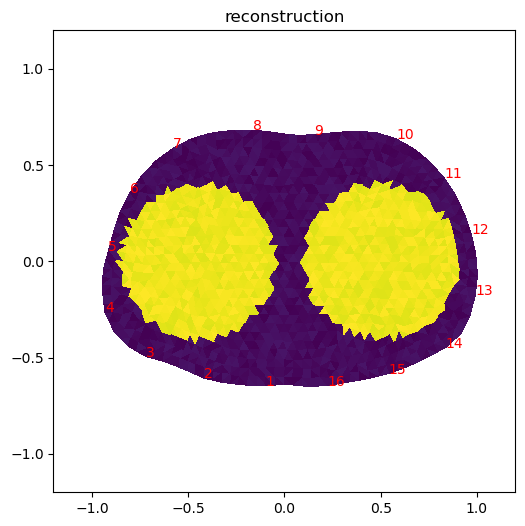

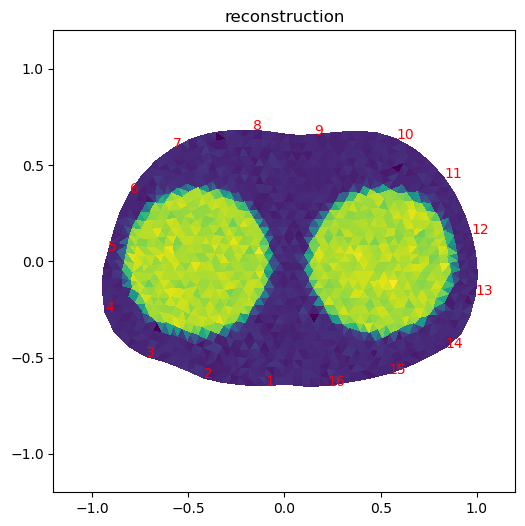

In [48]:
plot_reconstruction(mesh_obj, perms_test[0, :])
plot_reconstruction(mesh_obj, Perm_pred_stacked_lstm[0, :])
plot_reconstruction(mesh_obj, perms_test[25, :])
plot_reconstruction(mesh_obj, Perm_pred_stacked_lstm[25, :])
plot_reconstruction(mesh_obj, perms_test[50, :])
plot_reconstruction(mesh_obj, Perm_pred_stacked_lstm[50, :])

<a id="comparison"></a>
# Comparison

- [Stacked Mapper](#stackedmapper)
- [Single Layer Mapper](#singlelayer)
- [LSTM Mapper](#lstmmapper)
- [Stacked LSTM Mapper](#stackedlstmmapper)

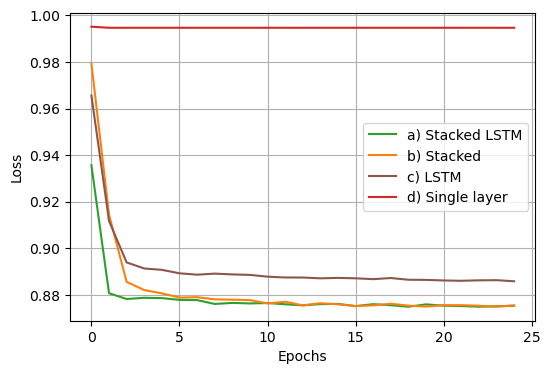

In [49]:
plt.figure(figsize=(6, 4))
plt.plot(history_stacked_lstm.history["loss"], c="C2", label="a) Stacked LSTM")
plt.plot(history_stacked.history["loss"], c="C1", label="b) Stacked")
plt.plot(history_lstm.history["loss"], c="C5", label="c) LSTM")
plt.plot(history_singlelayer.history["loss"], c="C3", label="d) Single layer")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [50]:
df = {
    "a) Stacked LSTM": err_stacked_lstm,
    "b) Stacked": err_stacked,
    "c) LSTM": err_lstm,
    "d) Single layer": err_singlelayer,
}  # tbd LSTM
DF = pd.DataFrame.from_dict(df)

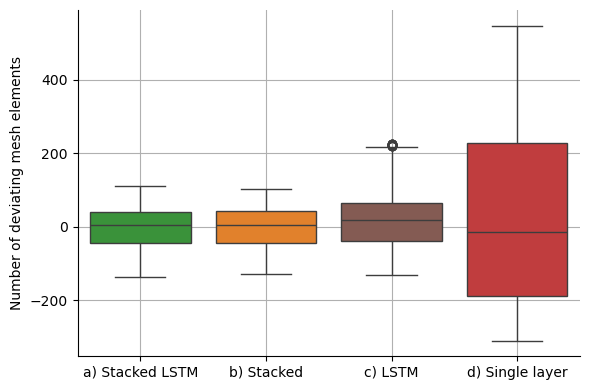

In [52]:
plt.figure(figsize=(6, 4))
# sns.set_theme(style="ticks", palette="muted")
sns.boxplot(
    data=DF, palette=["C2", "C1","C5", "C3"], showfliers=True
)  # set to false to hide outliers
sns.despine(offset=0, trim=False)
plt.ylabel("Number of deviating mesh elements")
plt.tight_layout()
plt.grid()
plt.savefig("../images/comparison.pdf")

- [Back to mapper training](#trainmapper)
- [Back to Top](#start)

_Contact:_ `jacob.thoenes@uni-rostock.de`